<a href="https://colab.research.google.com/github/jayapat/datascience_projects/blob/main/Deep_Learning_CIFAR10_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Font color = 'pickle'>**Load Libraries/Install Software**

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


In [ ]:
# Install wandb and update it to the latest version
if 'google.colab' in str(get_ipython()):
    !pip install wandb --upgrade -q

In [ ]:
# mount google drive
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, CyclicLR, OneCycleLR, StepLR

import numpy as np
import random

from datetime import datetime
from pathlib import Path
import sys
from types import SimpleNamespace

from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

import wandb


In [ ]:
# Login to W&B
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jayapat. Use `wandb login --relogin` to force relogin


True

# <Font color = 'pickle'>**Specify Project Folders**

In [ ]:
# This is the path where we will downlaod and save data
if 'google.colab' in str(get_ipython()):
  base_folder = Path('/content/drive/MyDrive/data')
else:
  base_folder = Path('G:/My Drive/Hw7')

In [ ]:
data_folder = base_folder/'datasets/cifar10/'
archive_folder = base_folder/'archive'
model_folder = base_folder/'models/dl_fall_2022/cifar10'
custom_functions = base_folder/'custom-functions'

In [ ]:
model_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
data_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
sys.path.append(str(custom_functions))

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/data/custom-functions']

In [ ]:
# from train_functions import train_loop, get_acc_pred

# <font color = 'pickle'>**CIFAR-10 Dataset**</font>

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Categories present in the dataset: 

- airplane : 0
- automobile : 1
- bird : 2
- cat : 3
- deer : 4
- dog : 5
- frog : 6
- horse : 7
- ship : 8
- truck : 9.

Let us download the dataset using some built-in functions.


## <Font color = 'pickle'>**Train and Test Dataset**


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),                                     
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download the training_validation data (we will create two subsets - trainset and valset frpm this)
train_set = torchvision.datasets.CIFAR10(root = data_folder, 
                                             train = True, 
                                             transform = train_transform, 
                                             download = True)

valid_set = torchvision.datasets.CIFAR10(root = data_folder, 
                                             train = True, 
                                             transform = valid_transform, 
                                             download = True)

# Download the testing data
testset = torchvision.datasets.CIFAR10(root = data_folder, 
                                            train = False, 
                                            transform = valid_transform, 
                                            download = True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## <Font color = 'pickle'>**Split train set to train/validation set**

In [ ]:
def split_dataset(base_dataset, fraction, seed):
    split_a_size = int(fraction * len(base_dataset))
    split_b_size = len(base_dataset) - split_a_size
    return torch.utils.data.random_split(base_dataset, [split_a_size, split_b_size], 
                                         generator=torch.Generator().manual_seed(seed)
    )

In [ ]:
trainset, _ = split_dataset(train_set, 0.8, 42)
_, validset = split_dataset(valid_set, 0.8, 42)

In [ ]:
# Since the transforms are not applied, we will manually first divide by 255
# we will then get the mean and std dev 
# the images are still in mumpy with the shape (number of images, H, W, Channels)
# Since we need mean, std dev 
train_data = train_set.data[trainset.indices]/255
train_data.shape
print(train_data.mean(axis = (0,1,2)))
print(train_data.std(axis = (0,1,2)))

[0.49171654 0.48256152 0.44711783]
[0.24705465 0.24350537 0.26166664]


## <Font color = 'pickle'>**Small Sample**

In [ ]:
# n sample points
train_sample_size = int(len(trainset)/500)
valid_sample_size = int(len(validset)/100)

# Getting n random indices
train_subset_indices = random.sample(range(0, len(trainset)), train_sample_size)
valid_subset_indices = random.sample(range(0, len(testset)), valid_sample_size)

# Getting subset of dataset
train_subset = torch.utils.data.Subset(trainset, train_subset_indices)
valid_subset = torch.utils.data.Subset(validset, valid_subset_indices)

## <Font color = 'pickle'>**Check inputs**

In [ ]:
print(type(trainset), type(trainset.dataset), type(trainset.indices), sep ='\n')

<class 'torch.utils.data.dataset.Subset'>
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'list'>


In [ ]:
trainset.indices[0:5]

[37542, 44491, 216, 43688, 41558]

In [ ]:
print(len(trainset), len(trainset.dataset), len(trainset.indices), sep ='\n')

40000
50000
40000


In [ ]:
print(len(validset), len(validset.dataset), len(validset.indices), sep ='\n')

10000
50000
10000


In [ ]:
# Shape of training data
len(trainset.indices), len(validset.indices)

(40000, 10000)

In [ ]:
print(train_set.data[trainset.indices].shape)
print(trainset.dataset.data[trainset.indices].shape)

(40000, 32, 32, 3)
(40000, 32, 32, 3)


In [ ]:
valid_set.data[validset.indices].shape

(10000, 32, 32, 3)

In [ ]:
# Shape of testing data
testset.data.shape

(10000, 32, 32, 3)

In [ ]:
# check the max value of inputs - the transformation are not yet applied.
# the transofrmation are applied iteratively on batches 
# when we craete batch by iterating over dataloader
train_set.data[trainset.indices].max()

255

In [ ]:
# check the min value of inputs
train_set.data[trainset.indices].min()

0

## <Font color = 'pickle'>**Check Labels**

In [ ]:
# check target values for train set
torch.tensor(train_set.targets)[trainset.indices]
#train_set.targets[trainset.indices]

tensor([6, 2, 8,  ..., 8, 4, 1])

In [ ]:
# Unique Target values
torch.tensor(train_set.targets)[trainset.indices].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
torch.tensor(valid_set.targets)[validset.indices].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
torch.tensor(testset.targets).unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## <Font color = 'pickle'>**Check Transformations**

- Check if transformation are working correctly.
- The transformations are applied at the time of calling dataloader

In [ ]:
# Initializing the batch size
batch_size = 32

check_loader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

In [ ]:
# check number of batches
len(check_loader)

625

In [ ]:
# check total training examples
len(check_loader.dataset)

40000

In [ ]:
# check imputs and outputs 
for input, target in check_loader:
  print(f'shape of inputs is :{input.shape}')
  print(f'\nmax input value  :{input.max()}')
  print(f'\nmin input value  :{input.min()}')
  print(f'\nmean input value  :{input.mean()}')
  print(f'\nstd input value  :{input.std()}')
  print(f'\nshape of targets is :{target.shape}')
  print(f'\ninputs  :{input[0, 0, 5:10, 5:10]}')
  
  break

shape of inputs is :torch.Size([64, 3, 224, 224])

max input value  :2.7537312507629395

min input value  :-2.429065704345703

mean input value  :-0.006258685141801834

std input value  :1.279892086982727

shape of targets is :torch.Size([64])

inputs  :tensor([[2.4753, 2.4753, 2.4753, 2.4753, 2.4753],
        [2.4753, 2.4753, 2.4753, 2.4753, 2.4753],
        [2.4947, 2.4947, 2.4947, 2.4947, 2.4947],
        [2.4947, 2.4947, 2.4947, 2.4947, 2.4947],
        [2.5141, 2.5141, 2.5141, 2.5141, 2.5141]])


# <Font color = 'pickle'>**Visualize the Data**

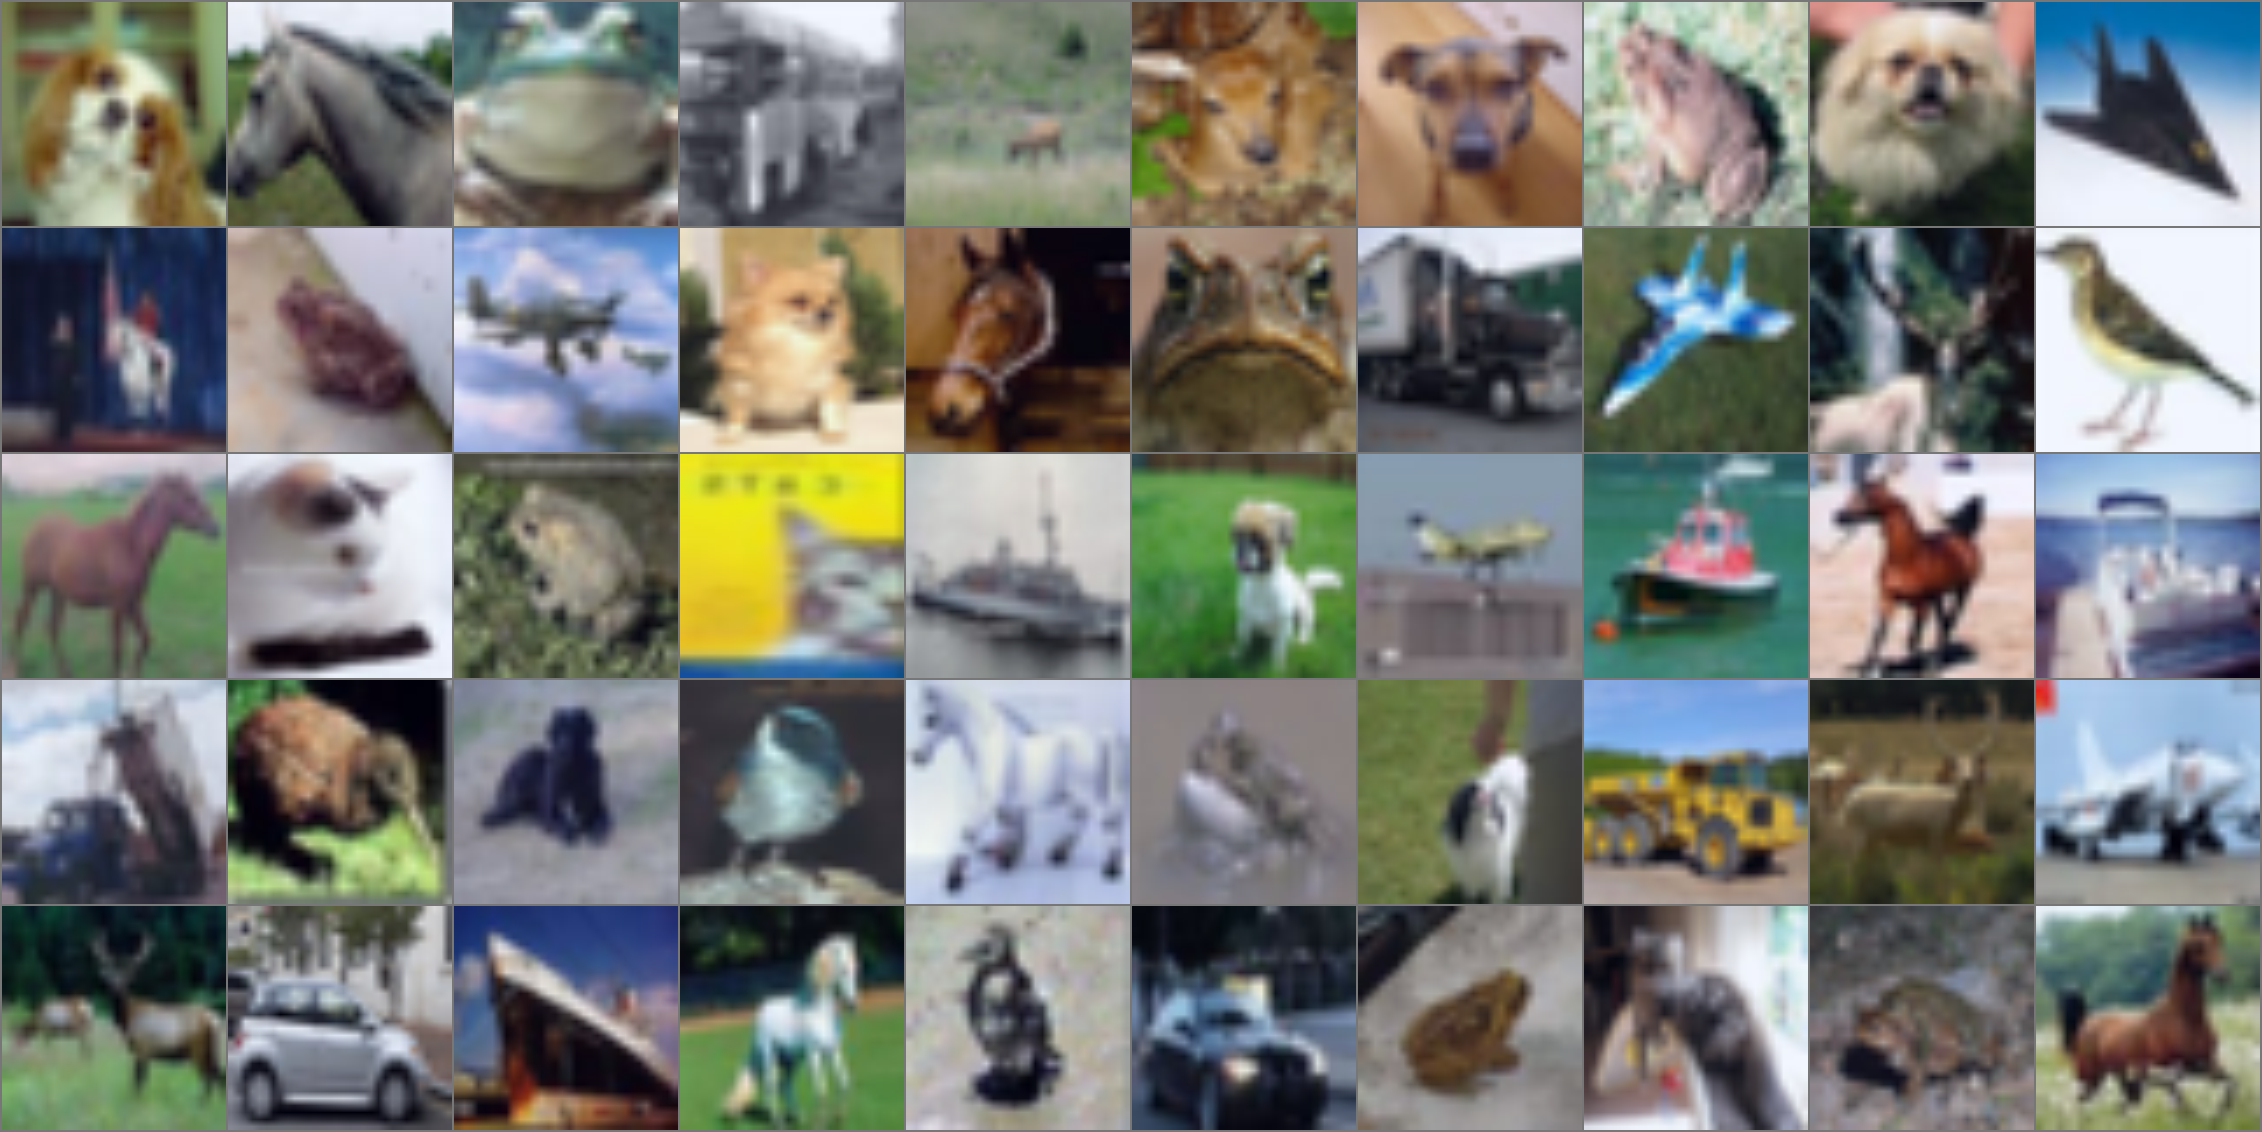

In [ ]:
# Get some random training images
dataiter = iter(check_loader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images[0:50], nrow = 10)

# Logging to W&B
images = wandb.Image(img_grid, caption = "Sample images")
images.image

In [ ]:
# Define the values for classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# <font color = 'pickle'> **Functions**

## <Font color = 'pickle'>**Function for Training  Loops**

**Model Training** involves five steps: 

- Step 0: Randomly initialize parameters / weights
- Step 1: Compute model's predictions - forward pass
- Step 2: Compute loss
- Step 3: Compute the gradients
- Step 4: Update the parameters
- Step 5: Repeat steps 1 - 4

Model training is repeating this process over and over, for many **epochs**.

We will specify number of ***epochs*** and during each epoch we will iterate over the complete dataset and will keep on updating the parameters.

***Learning rate*** and ***epochs*** are known as hyperparameters. We have to adjust the values of these two based on validation dataset.

We will now create functions for step 1 to 4.

In [ ]:
def train(train_loader, loss_function, model, optimizer, grad_clipping, max_norm, log_batch, log_interval):

  # Training Loop 

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_train

  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # put the model in training mode

  model.train()
  # Iterate on batches from the dataset using train_loader
  for input_, targets in train_loader:
    
    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)


    # Step 1: Forward Pass: Compute model's predictions 
    output = model(input_)
    
    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    batch_ct_train += 1

    # Step 3: Backward pass -Compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    if grad_clipping:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)

    # Step 4: Update the parameters
    optimizer.step()
    
    # For One Cycle Learning Rate - add step here
    scheduler.step()
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct

    # log batch loss and accuracy
    if log_batch:
      if ((batch_ct_train + 1) % log_interval) == 0:
        wandb.log({f"Train Batch Loss  :": loss})
        wandb.log({f"Train Batch Acc :": correct/len(targets)})
        print(f'Learning rate: {scheduler.get_last_lr()}')

  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)
  

  return train_loss, train_acc

## <Font color = 'pickle'>**Function for Validation Loops**


In [ ]:
def validate(valid_loader, loss_function, model, log_batch, log_interval):

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_valid

  # Validation/Test loop
  # Initialize valid_loss at the he strat of the epoch
  running_val_loss = 0
  running_val_correct = 0

  # put the model in evaluation mode
  model.eval()

  with torch.no_grad():
    for input_,targets in valid_loader:

      # move inputs and outputs to GPUs
      input_ = input_.to(device)
      targets = targets.to(device)

      # Step 1: Forward Pass: Compute model's predictions 
      output = model(input_)

      # Step 2: Compute loss
      loss = loss_function(output, targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      batch_ct_valid += 1

      # Add val loss of a batch 
      running_val_loss += loss.item()

      # Add correct count for each batch
      running_val_correct += correct

      # log batch loss and accuracy
      if log_batch:
        if ((batch_ct_valid + 1) % log_interval) == 0:
          wandb.log({f"Valid Batch Loss  :": loss})
          wandb.log({f"Valid Batch Accuracy :": correct/len(targets)})

    # Calculate mean val loss for the whole dataset for a particular epoch
    val_loss = running_val_loss/len(valid_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    val_acc = running_val_correct/len(valid_loader.dataset)

    # scheduler step
    scheduler.step(val_loss)
    scheduler.step()
    
  return val_loss, val_acc

## <Font color = 'pickle'>**Function for Model Training**
    
We will now create a function for step 5 of model training


In [ ]:
def train_loop(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience, early_stopping,
               file_model, save_best_model):
    
  """ 
  Function for training the model and plotting the graph for train & validation loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and validation loss for each epoch.
  """

  # Create lists to store train and val loss at each epoch
  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []

  # initialize variables for early stopping

  delta = 0
  best_score = None
  valid_loss_min = np.Inf
  counter_early_stop=0
  early_stop=False

  # Iterate for the given number of epochs
  # Step 5: Repeat steps 1 - 4

  for epoch in range(epochs):

    t0 = datetime.now()

    # Get train loss and accuracy for one epoch
    train_loss, train_acc = train(train_loader, loss_function, model, optimizer, 
                                  wandb.config.grad_clipping, wandb.config.max_norm,
                                  wandb.config.log_batch, wandb.config.log_interval)
    valid_loss, valid_acc   = validate(valid_loader, loss_function, model, wandb.config.log_batch, wandb.config.log_interval)

    dt = datetime.now() - t0

    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Log the train and valid loss to wandb
    wandb.log({f"Train Loss :": train_loss, "epoch": epoch})
    wandb.log({f"Train Acc :": train_acc, "epoch": epoch})

    wandb.log({f"Valid Loss :": valid_loss, "epoch": epoch})
    wandb.log({f"Valid Acc :": valid_acc, "epoch": epoch})

    if early_stopping:
      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        counter_early_stop += 1
        print(f'Early stoping counter: {counter_early_stop} out of {patience}')
        if counter_early_stop > patience:
          early_stop = True

      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        counter_early_stop=0
        valid_loss_min = valid_loss

      if early_stop:
        print('Early Stopping')
        break

    elif save_best_model:

      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        print(f'Validation loss has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model...')
      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss
        
    else:
        torch.save(model.state_dict(), file_model)
    
    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Time to complete {epoch+1} is {dt}')
    # print(f'Learning rate: {scheduler._last_lr[0]}') # for ReduceLR
    print(f'Learning rate: {scheduler.get_last_lr()}') # for OneCycle
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()
    torch.cuda.empty_cache()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

## <Font color = 'pickle'>**Function for Accuracy and Predictions**

Now we have final values for weights and bias after training the model. We will use these values to make predictions on the test dataset.

In [ ]:
def get_acc_pred(data_loader, model, device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Prections and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  # put the model in evaluation mode
  model.eval()
  
  # Iterate over batches from data iterator
  with torch.no_grad():
    for input_, targets in data_loader:
      
      # move inputs and outputs to GPUs
      
      input_ = input_.to(device)
      targets = targets.to(device)
      
      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      prediction = torch.argmax(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, prediction)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets)) 

  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, acc  

# <Font color = 'pickle'>**Model**

In [ ]:
def count_parameters(model): 
  """
  Function to count the number of trainable parameters in the model
  Input: model
  Output: Number of trainable parameters in the input model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
# Get the pre-trained GoogLeNet model
model_vgg = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Display the model structure
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Print the number of parameters in the model
print(count_parameters(model_vgg))

138357544


In [ ]:
model_resnet18 =  torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print(count_parameters(model_resnet18))

11689512


In [ ]:
count = 0
for child in model_resnet18.children():
    count+=1
    print(count)
    print()
    print(child)

1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
3

ReLU(inplace=True)
4

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
5

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

## <Font color = 'pickle'>**Model- Task1**

In [ ]:
# Task 1
vgg16_task1 = torchvision.models.vgg16(pretrained=True)
vgg16_task1.classifier[6].out_features = 10

# freeze convolution weights
for param in vgg16_task1.features.parameters():
    param.requires_grad = False

In [ ]:
count_parameters(vgg16_task1)

123642856

## <Font color = 'pickle'>**Model- Task2**

In [ ]:
# Task 2
vgg16_task2 = torchvision.models.vgg16(pretrained=True)
vgg16_task2.classifier[6].out_features = 10

# freeze convolution weights
for param in vgg16_task2.features[:24].parameters():
    param.requires_grad = False

In [ ]:
count_parameters(vgg16_task2)

130722280

## <Font color = 'pickle'>**Model- Task3**

In [ ]:
# Task 3
vgg16_task3 = torchvision.models.vgg16(pretrained=True)
vgg16_task3.classifier[6].out_features = 10

# freeze convolution weights
for param in vgg16_task3.features[:17].parameters():
    param.requires_grad = False

In [ ]:
count_parameters(vgg16_task3)

136622056

## <Font color = 'pickle'>**Model- Task4**

In [ ]:
# Task 4

resnet18_task4 = torchvision.models.resnet18(pretrained=True)
resnet18_task4.fc.out_features = 10

# Freeze all but last CNN block
count = 0
for child in resnet18_task4.children():
  count+=1
  if count < 8:
    for param in child.parameters():
        param.requires_grad = False



In [ ]:
count_parameters(resnet18_task4)

8906728

# <Font color = 'pickle'>**Meta Data**

In [ ]:
hyperparameters = SimpleNamespace(
    epochs = 3,
    batch_size=256,
    learning_rate=0.007,
    dataset="CIFAR10",
    architecture="Pretrained-VGG",
    log_interval = 100,
    log_batch = True,
    file_model = model_folder/'pre_vgg_cifar10.pt',
    grad_clipping = True,
    max_norm = 1,
    patience = 5,
    early_stopping = False,
    weight_decay = 0,
    save_best_model = True,
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    )

# <Font color = 'pickle'>**Data Loaders, Loss Function, Optimizer**

In [ ]:
# Initialize a new project
wandb.init(name = "task3_exp14", project = 'transfer_learning_cifar10' , config = hyperparameters)

In [ ]:
wandb.config = hyperparameters
wandb.config

namespace(architecture='Pretrained-VGG', batch_size=256, dataset='CIFAR10', device=device(type='cuda', index=0), early_stopping=False, epochs=3, file_model=PosixPath('/content/drive/MyDrive/data/models/dl_fall_2022/cifar10/pre_vgg_cifar10.pt'), grad_clipping=True, learning_rate=0.006, log_batch=True, log_interval=100, max_norm=1, patience=5, save_best_model=True, weight_decay=0)

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=wandb.config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=wandb.config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=wandb.config.batch_size,   shuffle = False)

model = vgg16_task3
model.to(wandb.config.device)
# model.apply(init_weights)

# loss_function
loss_function = nn.CrossEntropyLoss()
loss_function.to(wandb.config.device)
# soptimizer = torch.optim.Adam(model.parameters(), lr = wandb.config.learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr =0.009, 
                            weight_decay=wandb.config.weight_decay, momentum = 0.9)


scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1, total_steps= len(train_loader) * 20, epochs= 20 , three_phase=True)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# <Font color = 'pickle'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
i = 0
for input_, targets in train_loader:
  
  # move inputs and outputs to GPUs
  input_ = input_.to(device)
  targets = targets.to(device)
  model.eval()
  # Forward pass
  output = model(input_)
  loss = loss_function(output, targets)
  print(f'Actual loss: {loss}')
  i += 1

  if i >2:
    break
 

print(f'Expected Theoretical loss: {np.log(10)}')

Actual loss: 13.27283000946045
Actual loss: 13.62038516998291
Actual loss: 13.184106826782227
Expected Theoretical loss: 2.302585092994046


# <Font color = 'pickle'>**Training Model**

In [ ]:
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# See live graphs in the notebook.
#%%wandb 
batch_ct_train, batch_ct_valid = 0, 0
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(train_loader, 
                                                                                          valid_loader, 
                                                                                          model, 
                                                                                          optimizer, 
                                                                                          loss_function, 
                                                                                          wandb.config.epochs, 
                                                                                          wandb.config.device,
                                                                                          wandb.config.patience,
                                                                                          wandb.config.early_stopping,
                                                                                          wandb.config.file_model,
                                                                                          wandb.config.save_best_model)

Learning rate: [0.006598034493817961]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation loss has decreased (inf --> 0.568126). Saving Model...
Epoch : 1 / 3
Time to complete 1 is 0:12:39.094202
Learning rate: [0.00400065779789259]
Train Loss:  2.5178 | Train Accuracy:  45.0450%
Valid Loss:  0.5681 | Valid Accuracy:  79.9400%

Learning rate: [0.0045068782473763475]
Learning rate: [0.009409003445399688]
Validation loss has decreased (0.568126 --> 0.394262). Saving model...
Epoch : 2 / 3
Time to complete 2 is 0:12:49.492279
Learning rate: [0.004000520019950479]
Train Loss:  0.4860 | Train Accuracy:  83.1000%
Valid Loss:  0.3943 | Valid Accuracy:  86.4700%

Learning rate: [0.005982844117648975]
Validation loss has decreased (0.394262 --> 0.318611). Saving model...
Epoch : 3 / 3
Time to complete 3 is 0:13:03.844145
Learning rate: [0.004000465119678012]
Train Loss:  0.3344 | Train Accuracy:  88.5625%
Valid Loss:  0.3186 | Valid Accuracy:  88.9900%



# <Font color = 'pickle'>**Get Accuracy, Predictions**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model_saved= model
model_saved.to(device)
model_saved.load_state_dict(torch.load(wandb.config.file_model))

<All keys matched successfully>

In [ ]:
# Get the prediction and accuracy for the test dataseta
predictions_test, acc_test = get_acc_pred(test_loader, model_saved, device)
#predictions_train, acc_train = get_acc_pred(train_loader, model_saved, device)
#predictions_valid, acc_valid = get_acc_pred(valid_loader, model_saved, device)

In [ ]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
#print('Train accuracy', acc_train * 100)
#print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(88.6600, device='cuda:0')


In [ ]:
wandb.log({'Best_test_Acc': acc_test})
#wandb.log({'Best_train_Acc': acc_train})
#wandb.log({'Best_valid_Acc': acc_valid})

# <Font color = 'pickle'>**Confusion Matrix for Test Data**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [ ]:
# Get an array containing actual labels
testing_labels = np.array(([testset[i][1] for i in range(len(testset))]))

In [ ]:
np.unique(testing_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Log a confusion matrix to W&B
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                        probs = None,
                        y_true = testing_labels,
                        preds = predictions_test.to('cpu').numpy(),
                        class_names = classes)})


In [ ]:
wandb.finish()

Best_test_Acc,▁
Train Acc :,▁▇█
Train Batch Acc :,▁▆▆█
Train Batch Loss :,█▄▃▁
Train Loss :,█▁▁
Valid Acc :,▁▆█
Valid Batch Accuracy :,▁
Valid Batch Loss :,▁
Valid Loss :,█▃▁
epoch,▁▁▁▁▅▅▅▅████
Best_test_Acc,0.8866
